In [1]:
import pandas as pd
import time
import torch
import warnings
import seaborn as sns
import matplotlib.pyplot  as plt
from IPython import display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f' Device: {torch.cuda.get_device_name(0)}. Now using: {device.type}', '\n',
      f'Torch Version: {torch.version.__version__}')

 Device: NVIDIA GeForce RTX 4070 Ti. Now using: cuda 
 Torch Version: 2.2.1


In [2]:
df = pd.read_csv('simpsons_script_lines(1).csv', low_memory=False)
phrases = df['normalized_text'].tolist()  # колонка с предобработанными текстами
text = [[c for c in ph] for ph in phrases if type(ph) is str]

In [3]:
CHARS = set('abcdefghijklmnopqrstuvwxyz ')
INDEX_TO_CHAR = ['none'] + [w for w in CHARS]
CHAR_TO_INDEX = {w: i for i, w in enumerate(INDEX_TO_CHAR)}

MAX_LEN = 75
X = torch.zeros((len(text), MAX_LEN), dtype=int)
for i in range(len(text)): 
    for j, w in enumerate(text[i]): 
        if j >= MAX_LEN:
            break
        X[i, j] = CHAR_TO_INDEX.get(w, CHAR_TO_INDEX['none'])

In [4]:
class CustomRnnCell(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomRnnCell, self).__init__()
        self.hidden_size = hidden_size
        self.input_to_hidden = torch.nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, x, hidden_state):
        combined = torch.cat((x, hidden_state), 1)
        hidden_state = torch.tanh(self.input_to_hidden(combined))
        return hidden_state

In [11]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.hs = 1024
        self.embedding_dim = 64
        self.embedding = torch.nn.Embedding(28, self.embedding_dim)
        self.rnn_cell = CustomRnnCell(self.embedding_dim, self.hs)
        self.out = torch.nn.Linear(self.hs, 28)

    def forward(self, sentences, state=None):
        x = self.embedding(sentences)
        batch_size, sequence_length, _ = x.size()
        if state is None:
            state = torch.zeros(batch_size, self.hs).to(x.device)
        
        outputs = []
        for t in range(sequence_length):
            state = self.rnn_cell(x[:, t, :], state)
            outputs.append(state)
        
        outputs = torch.stack(outputs, dim=1)
        
        return self.out(outputs)

In [12]:
model = Network()
model.to(device)

Network(
  (embedding): Embedding(28, 64)
  (rnn_cell): CustomRnnCell(
    (input_to_hidden): Linear(in_features=1088, out_features=1024, bias=True)
  )
  (out): Linear(in_features=1024, out_features=28, bias=True)
)

In [13]:
criterion = torch.nn.CrossEntropyLoss() 

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001) 


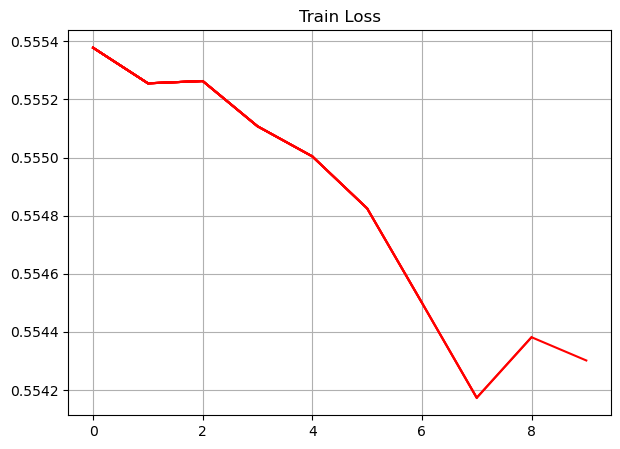

Epoch 9. Time: 54.0422, Train loss: 0.5543


In [20]:
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(7, 5))
ax.grid()
ax.set_title('Train Loss')

losses = []

model.load_state_dict(last_model_state)
optimizer.load_state_dict(last_optim_state)

for ep in range(10):
    start = time.time()
    train_loss = 0.
    train_passed = 0
    batch_size = 100

    for i in range(int(len(X) / batch_size)):
        batch = X[i * batch_size:(i + 1) * batch_size]
        X_batch = batch[:, :-1].to(device)
        Y_batch = batch[:, 1:].flatten().to(device)

        optimizer.zero_grad()
        answers = model.forward(X_batch)
        answers = answers.view(-1, len(INDEX_TO_CHAR))
        loss = criterion(answers, Y_batch)
        train_loss += loss.item()
        

        loss.backward()
        optimizer.step()
        
        train_passed += 1
    losses.append(train_loss / train_passed)
    sns.lineplot(losses, c='red', ax = ax)
    display.display(fig, clear=True)
    plt.close()

    print("Epoch {}. Time: {:.4f}, Train loss: {:.4f}".format(ep, time.time() - start, train_loss / train_passed))

In [21]:
#Обучается только с очень низким LR. Несколько циклов обучения, чтобы достичь приемлемого значения функции потерь.

last_model_state = model.state_dict()
last_optim_state = optimizer.state_dict()

In [22]:
torch.save(model.state_dict(), 'custom_rnn_weights.pth')
torch.save(optimizer.state_dict(), 'custom_rnn_optimizer.pth')

In [162]:
def generate_phrase(prompt):
    prompt = prompt
    prompt_list = list(prompt)
    prompt_ind = [CHAR_TO_INDEX.get(s, 0) for s in prompt_list]

    answers = model.forward(torch.tensor(prompt_ind).unsqueeze(0).to(device))
    _, index = answers.topk(1)
    last_index = index.flatten()[-1].item()
    if last_index == 0:
        return prompt
    prompt_ind.append(last_index)
    prompt = ''.join([INDEX_TO_CHAR[ind] for ind in prompt_ind])
    return prompt
    # return ''.join([INDEX_TO_CHAR[ind] for ind in prompt_ind])


In [167]:
prompt = 'crusty'
while len(prompt) <= 100:
    new_prompt = generate_phrase(prompt)
    if new_prompt == prompt:
        break
    prompt = new_prompt

print(prompt)

crusty the clown your son is a problem with the thing ive got to stop her anymore i want to see the t
